In [1]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

C:\Users\kangs\miniconda3\envs\ADP-study\lib\site-packages\matplotlib\cbook\__init__.py:1395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 800x500 with 1 Axes>

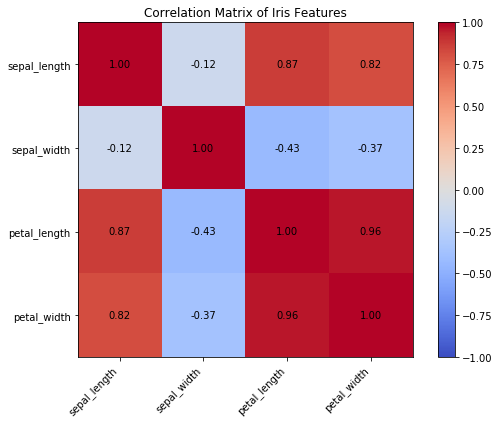

In [2]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import matplotlib.pyplot as plt
import platform

# 운영체제에 맞는 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':  # Mac OS
    plt.rc('font', family='AppleGothic')
else:  # Linux
    # 사전에 나눔고딕 설치 필요
    # sudo apt-get install -y fonts-nanum*
    # fc-cache -fv
    plt.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

전체 데이터셋의 실루엣 계수: 0.7911


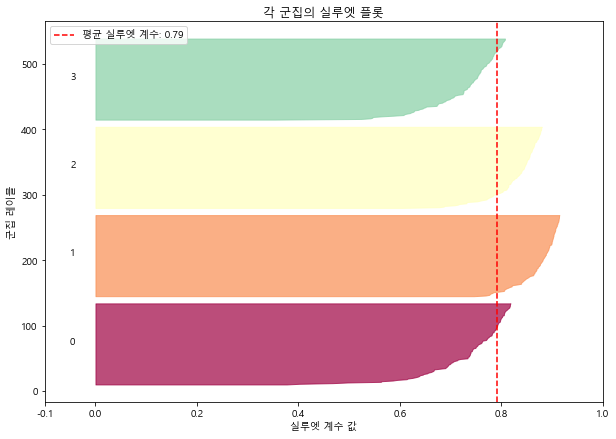

군집 개수 = 2, 실루엣 계수 = 0.5955
군집 개수 = 3, 실루엣 계수 = 0.7613
군집 개수 = 4, 실루엣 계수 = 0.7911
군집 개수 = 5, 실루엣 계수 = 0.6647
군집 개수 = 6, 실루엣 계수 = 0.5614


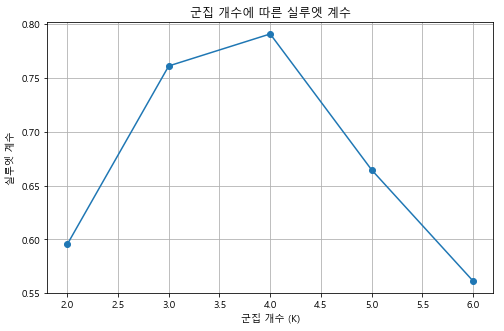

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# 1. 예시 데이터 생성
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1.0, random_state=42)

# 2. K-Means 군집화 수행 (예: K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

# 3. 실루엣 계수 계산
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"전체 데이터셋의 실루엣 계수: {silhouette_avg:.4f}")

# 4. 각 샘플의 실루엣 계수 계산 및 시각화
sample_silhouette_values = silhouette_samples(X, cluster_labels)

plt.figure(figsize=(10, 7))
y_lower = 10
for i in range(4): # 4개의 군집
    # 해당 군집의 실루엣 값들을 정렬
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.Spectral(float(i) / 4)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 # 다음 막대를 위한 공간

plt.title("각 군집의 실루엣 플롯")
plt.xlabel("실루엣 계수 값")
plt.ylabel("군집 레이블")
plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'평균 실루엣 계수: {silhouette_avg:.2f}')
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.legend()
plt.show()

# 5. 최적의 K 찾기
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"군집 개수 = {n_clusters}, 실루엣 계수 = {silhouette_avg:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("군집 개수에 따른 실루엣 계수")
plt.xlabel("군집 개수 (K)")
plt.ylabel("실루엣 계수")
plt.grid(True)
plt.show()

혼동 행렬 (scikit-learn): [[3 2]
 [1 4]]


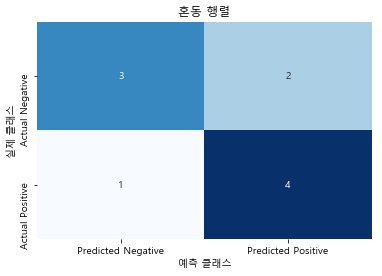

다중 클래스 혼동 행렬: [[3 0 0]
 [1 1 1]
 [0 1 2]]


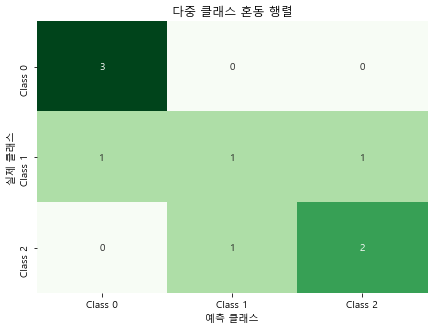

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예시 데이터
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

# scikit-learn을 이용한 혼동 행렬
cm = confusion_matrix(y_true, y_pred)
print("혼동 행렬 (scikit-learn):", cm)

# 혼동 행렬 시각화 (seaborn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('혼동 행렬')
plt.show()

# 다중 클래스 분류 예시
y_true_multi = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
y_pred_multi = np.array([0, 1, 1, 0, 2, 2, 0, 0, 2])

cm_multi = confusion_matrix(y_true_multi, y_pred_multi)
print("다중 클래스 혼동 행렬:", cm_multi)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_multi, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.title('다중 클래스 혼동 행렬')
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# 예시 데이터
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

# scikit-learn을 이용한 정확도 계산
accuracy = accuracy_score(y_true, y_pred)
print(f"정확도 (Accuracy): {accuracy:.4f}")

# 혼동 행렬을 이용한 수동 계산
cm = confusion_matrix(y_true, y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
manual_accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"수동 계산 정확도: {manual_accuracy:.4f}")

정확도 (Accuracy): 0.7000
수동 계산 정확도: 0.7000


In [10]:
import numpy as np
from sklearn.metrics import precision_score, confusion_matrix

# 예시 데이터
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

# scikit-learn을 이용한 정밀도 계산
precision = precision_score(y_true, y_pred)
print(f"정밀도 (Precision): {precision:.4f}")

# 혼동 행렬을 이용한 수동 계산
cm = confusion_matrix(y_true, y_pred)
TP = cm[1, 1]
FP = cm[0, 1]
manual_precision = TP / (TP + FP)
print(f"수동 계산 정밀도: {manual_precision:.4f}")

# 다중 클래스 분류에서의 정밀도 (average 파라미터)
y_true_multi = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
y_pred_multi = np.array([0, 1, 1, 0, 2, 2, 0, 0, 2])

# 'macro': 각 클래스별 정밀도를 계산한 후 평균 (클래스 불균형에 민감)
precision_macro = precision_score(y_true_multi, y_pred_multi, average='macro')
print(f"다중 클래스 정밀도 (macro): {precision_macro:.4f}")

# 'weighted': 각 클래스별 정밀도를 계산한 후 샘플 수에 따라 가중 평균
precision_weighted = precision_score(y_true_multi, y_pred_multi, average='weighted')
print(f"다중 클래스 정밀도 (weighted): {precision_weighted:.4f}")

# 'micro': 전체 TP, FP, FN을 합산하여 계산 (Accuracy와 동일)
precision_micro = precision_score(y_true_multi, y_pred_multi, average='micro')
print(f"다중 클래스 정밀도 (micro): {precision_micro:.4f}")

# 'None': 각 클래스별 정밀도 반환
precision_per_class = precision_score(y_true_multi, y_pred_multi, average=None)
print(f"다중 클래스 정밀도 (클래스별): {precision_per_class}")

정밀도 (Precision): 0.6667
수동 계산 정밀도: 0.6667
다중 클래스 정밀도 (macro): 0.6389
다중 클래스 정밀도 (weighted): 0.6389
다중 클래스 정밀도 (micro): 0.6667
다중 클래스 정밀도 (클래스별): [0.75       0.5        0.66666667]


In [11]:
import numpy as np
from sklearn.metrics import recall_score, confusion_matrix

# 예시 데이터
y_true = np.array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
y_pred = np.array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1])

# scikit-learn을 이용한 재현율 계산
recall = recall_score(y_true, y_pred)
print(f"재현율 (Recall): {recall:.4f}")

# 혼동 행렬을 이용한 수동 계산
cm = confusion_matrix(y_true, y_pred)
TP = cm[1, 1]
FN = cm[1, 0]
manual_recall = TP / (TP + FN)
print(f"수동 계산 재현율: {manual_recall:.4f}")

# 다중 클래스 분류에서의 재현율 (average 파라미터)
y_true_multi = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
y_pred_multi = np.array([0, 1, 1, 0, 2, 2, 0, 0, 2])

# 'macro': 각 클래스별 재현율을 계산한 후 평균 (클래스 불균형에 민감)
recall_macro = recall_score(y_true_multi, y_pred_multi, average='macro')
print(f"다중 클래스 재현율 (macro): {recall_macro:.4f}")

# 'weighted': 각 클래스별 재현율을 계산한 후 샘플 수에 따라 가중 평균
recall_weighted = recall_score(y_true_multi, y_pred_multi, average='weighted')
print(f"다중 클래스 재현율 (weighted): {recall_weighted:.4f}")

# 'micro': 전체 TP, FN을 합산하여 계산 (Accuracy와 동일)
recall_micro = recall_score(y_true_multi, y_pred_multi, average='micro')
print(f"다중 클래스 재현율 (micro): {recall_micro:.4f}")

# 'None': 각 클래스별 재현율 반환
recall_per_class = recall_score(y_true_multi, y_pred_multi, average=None)
print(f"다중 클래스 재현율 (클래스별): {recall_per_class}")

재현율 (Recall): 0.8000
수동 계산 재현율: 0.8000
다중 클래스 재현율 (macro): 0.6667
다중 클래스 재현율 (weighted): 0.6667
다중 클래스 재현율 (micro): 0.6667
다중 클래스 재현율 (클래스별): [1.         0.33333333 0.66666667]


AUC (수동 계산): 0.9124
AUC (scikit-learn): 0.9124


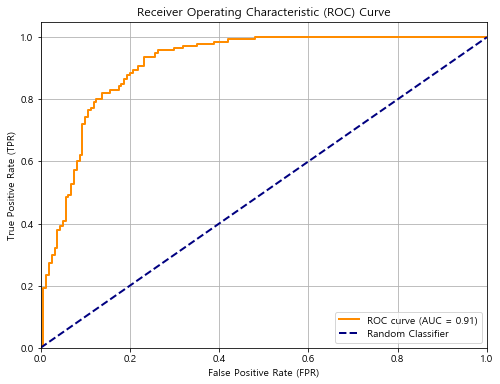

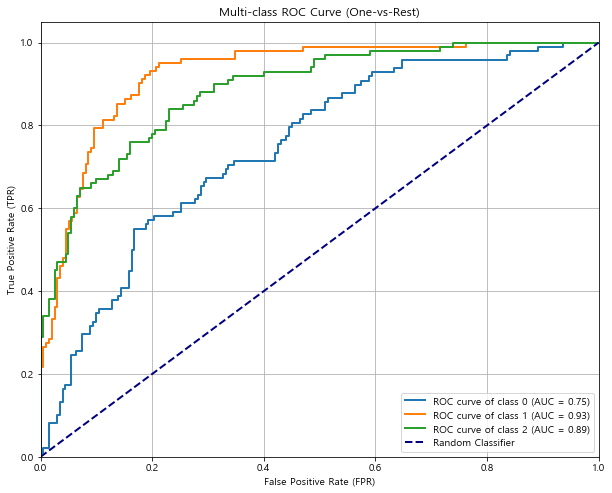

다중 클래스 AUC (macro): 0.8527
다중 클래스 AUC (weighted): 0.8539


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# 예시 데이터 생성 (이진 분류)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression(random_state=42, solver='liblinear')
model.fit(X_train, y_train)

# 예측 확률 얻기 (양성 클래스에 대한 확률)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# AUC 계산
roc_auc = auc(fpr, tpr)
print(f"AUC (수동 계산): {roc_auc:.4f}")            # 0.9124

# scikit-learn을 이용한 AUC 계산
roc_auc_sklearn = roc_auc_score(y_test, y_pred_proba)
print(f"AUC (scikit-learn): {roc_auc_sklearn:.4f}") # 0.9124

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 다중 클래스 분류 예시 (One-vs-Rest)
from sklearn.preprocessing import LabelBinarizer

# 예시 데이터 생성 (다중 클래스 분류)
X_multi, y_multi = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, n_classes=3, random_state=42)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

# 로지스틱 회귀 모델 학습
model_multi = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr')
model_multi.fit(X_train_multi, y_train_multi)

# 예측 확률 얻기
y_pred_proba_multi = model_multi.predict_proba(X_test_multi)

# 각 클래스에 대한 ROC Curve 및 AUC 계산
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test_multi)

plt.figure(figsize=(10, 8))
for i in range(y_multi.max() + 1):
    fpr_multi, tpr_multi, _ = roc_curve(y_test_binarized[:, i], y_pred_proba_multi[:, i])
    roc_auc_multi = auc(fpr_multi, tpr_multi)
    plt.plot(fpr_multi, tpr_multi, lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc_multi:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 다중 클래스 AUC (macro, weighted)
auc_macro_multi = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='macro')
auc_weighted_multi = roc_auc_score(y_test_multi, y_pred_proba_multi, multi_class='ovr', average='weighted')
print(f"다중 클래스 AUC (macro): {auc_macro_multi:.4f}")       # 0.8527
print(f"다중 클래스 AUC (weighted): {auc_weighted_multi:.4f}") # 0.8539